# Contents

* [Overview](#0)
* [Importing Libraries](#1)
* [Loading Dataset](#2)
* [Data Visualization](#3)
* [Text Preprocessing](#4)
* [Building Model with Sklearn](#5)
* [Building Model with Tensorflow](#6)
* [Prediction](#7)

<a id="0"></a>
<h1><b><span style="color: #e56b6f; font-size: 28px">OVERVIEW</span></b></h1>

In this project, we are going to do semantic analysis on hotel reviews from Tripadvisor. We will use the following approach:
1. With machine learning models using sklearn
2. With deep neural network using tensorflow

There are also some text preprocessing before we train our model to make sure that our data is clean. At the end of this notebook, we will try to predict the sentiment of our own review

<a id="1"></a>
<h1><b><span style="color: #e56b6f; font-size: 28px">IMPORTING LIBRARIES</span></b></h1>

In [1]:
# nltk is one of the most useful libraries when it comes to nlp
#!pip install nltk

In [1]:
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
from wordcloud import WordCloud

# Preprocessing and evaluation
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l1, l2

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

2024-02-14 11:58:25.357387: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-14 11:58:25.518969: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-14 11:58:25.519039: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-14 11:58:25.547655: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-14 11:58:25.609073: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-14 11:58:25.610055: I tensorflow/core/platform/cpu_feature_guard.cc:1

<a id="1"></a>
<h1><b><span style="color: #e56b6f; font-size: 28px">LOADING DATASET</span></b></h1>

In [2]:
df = pd.read_csv('tripadvisor_hotel_reviews.csv')
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


As you can see from above details, there is **no null values** in this dataset

<a id="3"></a>
<h1><b><span style="color: #e56b6f; font-size: 28px">DATA VISUALIZATION</span></b></h1>

/tmp/ipykernel_12726/1936218408.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Rating', palette='flare').set_title('Rating Distribution Across Dataset')


Text(0.5, 1.0, 'Rating Distribution Across Dataset')

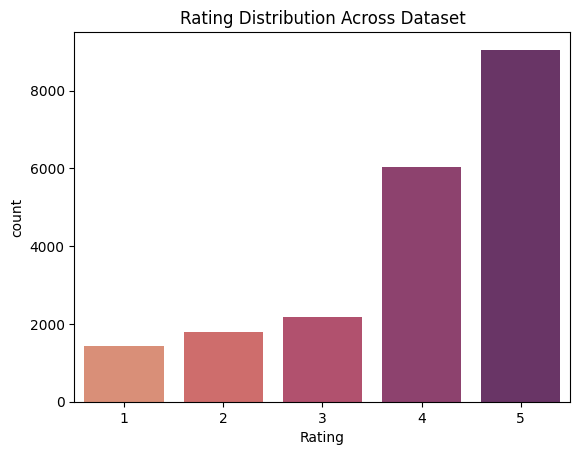

In [4]:
sns.countplot(data=df, x='Rating', palette='flare').set_title('Rating Distribution Across Dataset')

In [5]:
# Length of word in sentence
df['Length'] = df['Review'].apply(len)
df.head()

,Review,Rating,Length
0,nice hotel expensive parking got good deal sta...,4,593
1,ok nothing special charge diamond member hilto...,2,1689
2,nice rooms not 4* experience hotel monaco seat...,3,1427
3,"unique, great stay, wonderful time hotel monac...",5,600
4,"great stay great stay, went seahawk game aweso...",5,1281


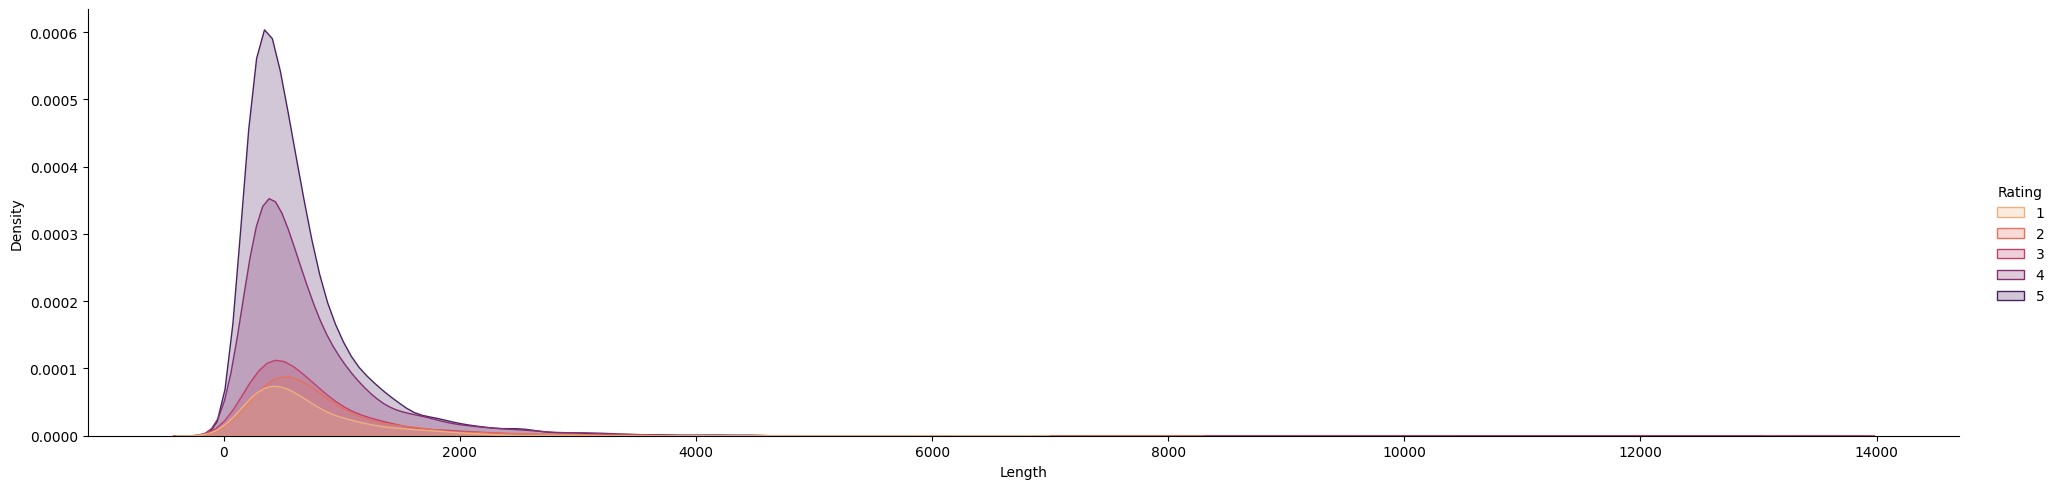

In [6]:
sns.displot(data=df, x='Length', hue='Rating', palette='flare', kind='kde', fill=True, aspect=4)

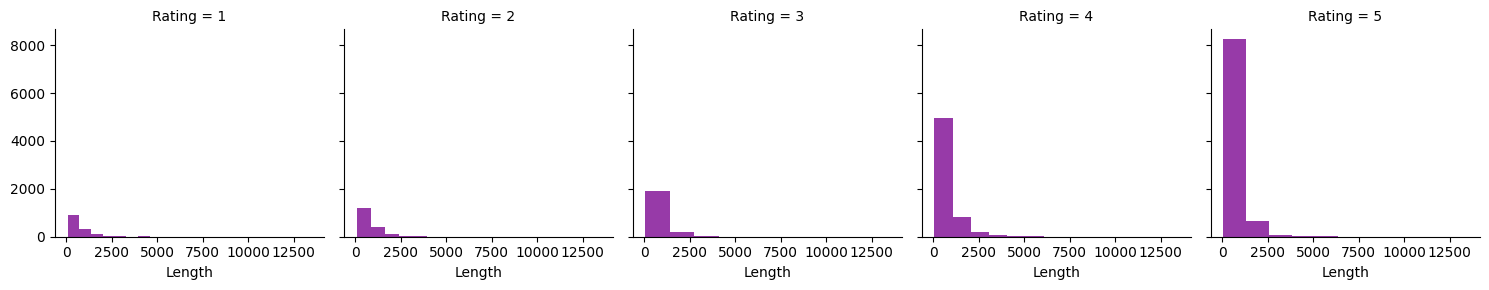

In [7]:
g = sns.FacetGrid(data=df, col='Rating')
g.map(plt.hist, 'Length', color='#973aa8')

- From above plots we can say that **the higher the rating of the hotel, the more likely the visitors WROTE a long review**

<a id="4"></a>
<h1><b><span style="color: #e56b6f; font-size: 28px">TEXT PREPROCESSING</span></b></h1>

In [8]:
# Change the rating to be more general and easier to understand
def rating(score):
    if score > 3:
        return 'Good'
    #elif score == 3:
        #return 'Netral'
    else:
        return 'Bad'

In [9]:
df['Rating'] = df['Rating'].apply(rating)

In [10]:
# ENCODE SENTIMENT -> 0 & 1
df['Rating'] = df['Rating'].replace('Good', 1)
df['Rating'] = df['Rating'].replace('Bad', 0)

In [11]:
df.head()

,Review,Rating,Length
0,nice hotel expensive parking got good deal sta...,1,593
1,ok nothing special charge diamond member hilto...,0,1689
2,nice rooms not 4* experience hotel monaco seat...,0,1427
3,"unique, great stay, wonderful time hotel monac...",1,600
4,"great stay great stay, went seahawk game aweso...",1,1281


In [12]:
# Total word in dataset before cleaning
length = df['Length'].sum()

<h1 style="font-family: Trebuchet MS; font-size: 20px; color: #da627d; text-align: left; "><b>Stemming vs Lemmatization</b></h1>

In [13]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /home/a10/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/a10/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
print('Original:')
print(df['Review'][0])
print()

sentence = []
for word in df['Review'][0].split():
    stemmer = SnowballStemmer('english')
    sentence.append(stemmer.stem(word))
print('Stemming:')
print(' '.join(sentence))
print()

sentence = []
for word in df['Review'][0].split():
    lemmatizer = WordNetLemmatizer()
    sentence.append(lemmatizer.lemmatize(word, 'v'))
print('Lemmatization:')
print(' '.join(sentence))

Original:
nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night,  

Stemming:
nice hotel expens park got good deal stay hotel anniversary, arriv late even took advic previous review did valet parking, check quick easy, littl disappoint non-exist view room room clean nice size, bed comfort woke stiff neck high pillows, not soundproof like heard music room night morn loud bang door open close hear peopl talk hallway, mayb just noisi neighbors, aveda bath produc

There are some difference among those 3 sentences, for instance:
* Original -> got, arrived
* Stemming -> got, arriv
* Lemmatization -> get, arrive

This time, we will use Lemmatization in order to get the base form of the word

In [15]:
def cleaning(text):
    #remove punctuations and uppercase
    clean_text = text.translate(str.maketrans('','',string.punctuation)).lower()

    #remove stopwords
    clean_text = [word for word in clean_text.split() if word not in stopwords.words('english')]

    #lemmatize the word
    sentence = []
    for word in clean_text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word, 'v'))

    return ' '.join(sentence)

In [16]:
df['Review'] = df['Review'].apply(cleaning)

In [17]:
df['Length'] = df['Review'].apply(len)
new_length = df['Length'].sum()

print('Total text length before cleaning: {}'.format(length))
print('Total text length after cleaning: {}'.format(new_length))

Total text length before cleaning: 14853861
Total text length after cleaning: 13543965


In [22]:
#df.to_csv('cleaned_df.csv', index=False)

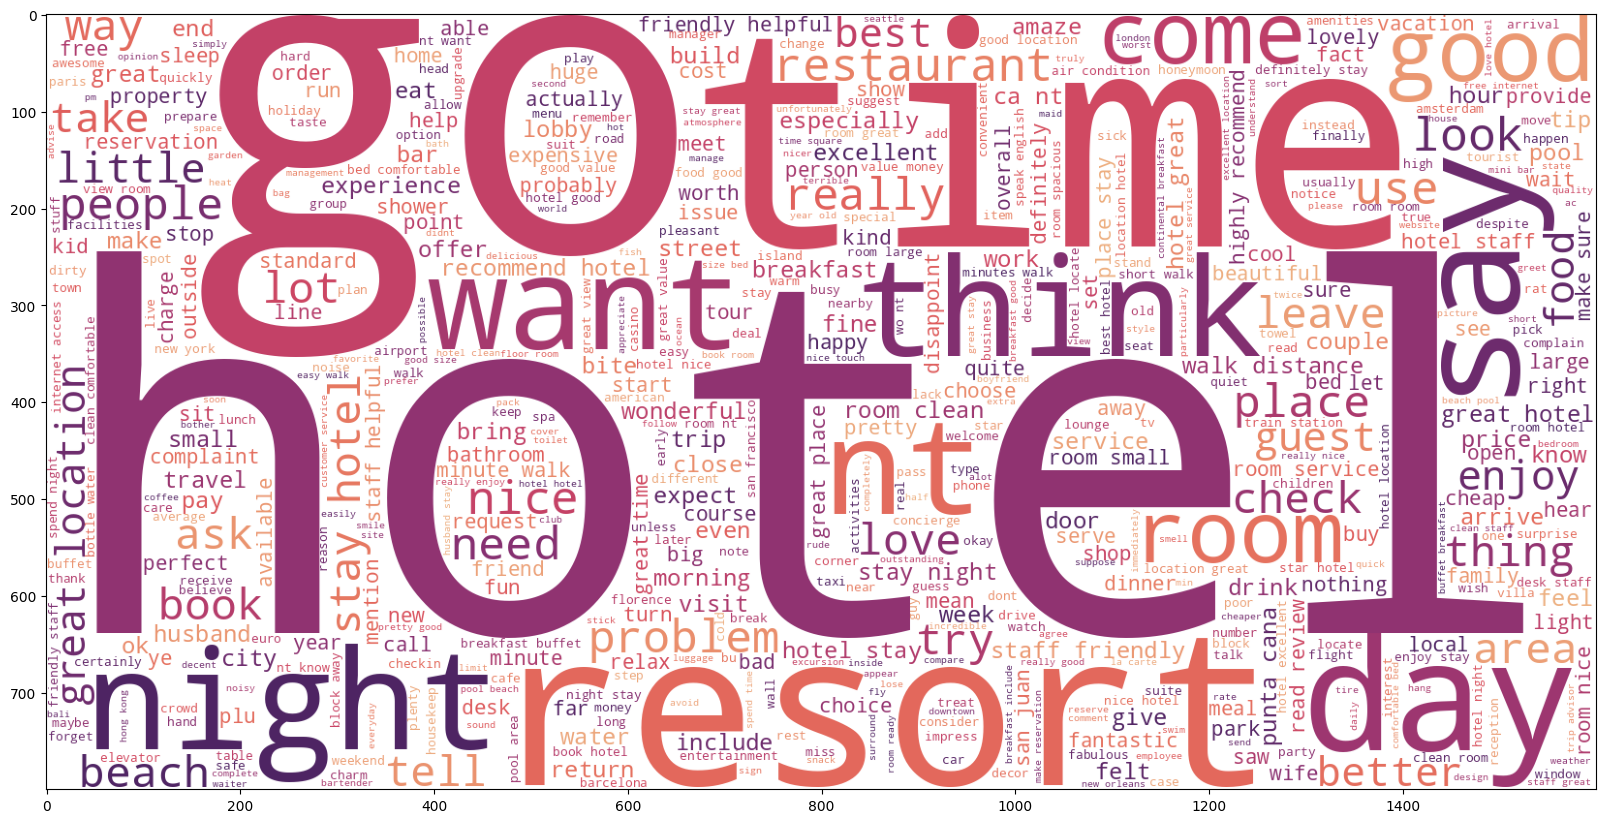

In [18]:
# After cleaning, let's see the most common used word
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=1000, min_font_size=10,
                height=800,width=1600,background_color="white", colormap='flare').generate(' '.join(df['Review']))

plt.imshow(wc)

In [19]:
df['Rating'].value_counts()

Rating
1    15093
0     5398
Name: count, dtype: int64

In [20]:
X_train, X_test, y_train, y_test = train_test_split(df['Review'], df['Rating'], test_size=0.2)

<a id="5"></a>
<h1><b><span style="color: #e56b6f; font-size: 28px">BUILDING MODEL WITH SKLEARN</span></b></h1>

In [21]:
tfid = TfidfVectorizer()
train_tfid_matrix = tfid.fit_transform(X_train)
test_tfid_matrix = tfid.transform(X_test)

In [22]:
pickle.dump(tfid, open('tfidf.pkl', 'wb'))

In [23]:
models = [DecisionTreeClassifier(),
          RandomForestClassifier(),
          SVC(),
          LogisticRegression()]

In [24]:
accuracy = []
precision = []
recall = []
f1_score = []

for model in models:
    model.fit(train_tfid_matrix, y_train)
    y_pred = model.predict(test_tfid_matrix)

    # Accuracy
    accuracy.append(model.score(test_tfid_matrix, y_test))

    # Precision, Recall, F1 Score
    report = classification_report(y_test, y_pred, output_dict=True)
    precision.append(report['macro avg']['precision'])
    recall.append(report['macro avg']['recall'])
    f1_score.append(report['macro avg']['f1-score'])

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix for", type(model).__name__)
    print(cm)
    print()

Confusion Matrix for DecisionTreeClassifier
[[ 608  501]
 [ 431 2559]]

Confusion Matrix for RandomForestClassifier
[[ 392  717]
 [  10 2980]]

Confusion Matrix for SVC
[[ 799  310]
 [ 109 2881]]

Confusion Matrix for LogisticRegression
[[ 783  326]
 [  97 2893]]



In [25]:
# DataFrame with accuracy, precision, recall, and F1 score
models_name = ['DecisionTreeClassifier', 'RandomForestClassifier', 'SVC','Logistic Regression']
results = pd.DataFrame({
    'Model': models_name,
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1_score
})

In [26]:
results

,Model,Accuracy,Precision,Recall,F1 Score
0,DecisionTreeClassifier,0.772627,0.710726,0.702047,0.706029
1,RandomForestClassifier,0.822640,0.890592,0.675064,0.705072
2,SVC,0.897780,0.891404,0.842007,0.862239
3,Logistic Regression,0.896804,0.894250,0.836800,0.859602


Since Logistic Regression performs better than other models in this case, we will use it to train our model

In [40]:
log = LogisticRegression(max_iter=1000)
log.fit(train_tfid_matrix, y_train)

pred = log.predict(test_tfid_matrix)

In [41]:
pickle.dump(log, open('ml_model.pkl', 'wb'))

In [42]:
ml = pickle.load(open('ml_model.pkl','rb'))
tfidf = pickle.load(open('tfidf.pkl','rb'))
def ml_predict(text):
    clean_text = cleaning(text)
    tfid_matrix = tfidf.transform([clean_text])
    pred_proba = ml.predict_proba(tfid_matrix)
    idx = np.argmax(pred_proba)
    pred = ml.classes_[idx]

    return pred, pred_proba[0][idx]

ml_predict('poor room service')

(0, 0.9791021321632218)

In [30]:
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[ 783  326]
 [  97 2893]]
              precision    recall  f1-score   support

           0       0.89      0.71      0.79      1109
           1       0.90      0.97      0.93      2990

    accuracy                           0.90      4099
   macro avg       0.89      0.84      0.86      4099
weighted avg       0.90      0.90      0.89      4099



<a id="6"></a>
<h1><b><span style="color: #e56b6f; font-size: 28px">OPTIONAL - BUILDING MODEL WITH TENSORFLOW</span></b></h1>

In [31]:
tokenizer = Tokenizer(num_words=50000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
total_word = len(tokenizer.word_index)
print('Total distinct words: {}'.format(total_word))

train_seq = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_seq)

test_seq = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_seq)

# Mapping the labels to binary values
#train_labels = np.array([1 if label == 'positive' else 0 for label in y_train])
#test_labels = np.array([1 if label == 'positive' else 0 for label in y_test])

Total distinct words: 65030


In [32]:
pickle.dump(tokenizer, open('tokenizer.pkl', 'wb'))

In [33]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(total_word, 8),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(8, kernel_regularizer=tf.keras.regularizers.l2(0.001),
                          bias_regularizer=tf.keras.regularizers.l2(0.001), activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 8)           520240    
                                                                 
 bidirectional (Bidirection  (None, 32)                3200      
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 8)                 264       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                        

In [34]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(train_padded, y_train, epochs=25, validation_data=(test_padded, y_test))

Epoch 1/25
513/513 [==============================] - 246s 475ms/step - loss: 0.6516 - accuracy: 0.7184 - val_loss: 0.5973 - val_accuracy: 0.7294
Epoch 2/25
513/513 [==============================] - 245s 477ms/step - loss: 0.6036 - accuracy: 0.7307 - val_loss: 0.5433 - val_accuracy: 0.7294
Epoch 3/25
513/513 [==============================] - 244s 476ms/step - loss: 0.5299 - accuracy: 0.7304 - val_loss: 0.4728 - val_accuracy: 0.7294
Epoch 4/25
513/513 [==============================] - 244s 476ms/step - loss: 0.4867 - accuracy: 0.7346 - val_loss: 0.4283 - val_accuracy: 0.7294
Epoch 5/25
513/513 [==============================] - 245s 478ms/step - loss: 0.4477 - accuracy: 0.7344 - val_loss: 0.6927 - val_accuracy: 0.7294
Epoch 6/25
513/513 [==============================] - 245s 478ms/step - loss: 0.4467 - accuracy: 0.7444 - val_loss: 0.3914 - val_accuracy: 0.7294
Epoch 7/25
513/513 [==============================] - 244s 476ms/step - loss: 0.4054 - accuracy: 0.8011 - val_loss: 0.3733 -

<Axes: >

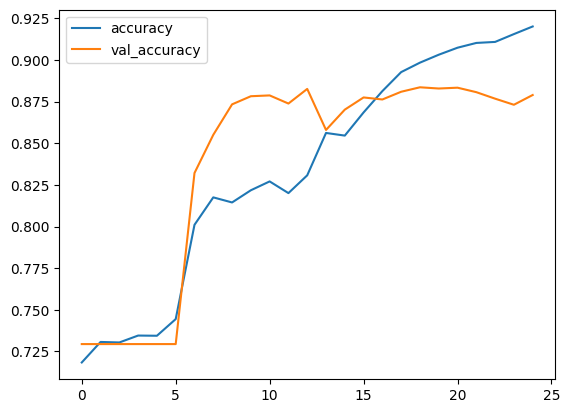

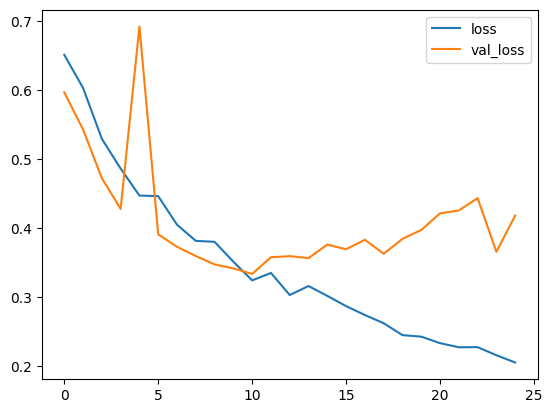

In [35]:
metrics = pd.DataFrame(model.history.history)
metrics[['accuracy', 'val_accuracy']].plot()
metrics[['loss', 'val_loss']].plot()

In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

pred_probs = model.predict(test_padded)
pred_labels = (pred_probs > 0.5).astype(int).flatten()
true_labels = y_test
print(confusion_matrix(true_labels, pred_labels))
print(classification_report(true_labels, pred_labels))

accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels)
recall = recall_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

129/129 [==============================] - 7s 47ms/step
[[ 830  279]
 [ 217 2773]]
              precision    recall  f1-score   support

           0       0.79      0.75      0.77      1109
           1       0.91      0.93      0.92      2990

    accuracy                           0.88      4099
   macro avg       0.85      0.84      0.84      4099
weighted avg       0.88      0.88      0.88      4099

Accuracy: 0.8789948767992193
Precision: 0.9085845347313237
Recall: 0.9274247491638796
F1 Score: 0.917907977490897


In [37]:
model.save('dl_model.h5')

/home/a10/anaconda3/envs/eda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<a id="7"></a>
<h1><b><span style="color: #e56b6f; font-size: 28px">PREDICTION</span></b></h1>

Let's make some prediction using the model we have trained. You can create your own reviews and let the model predict the sentiment in your text

In [52]:
# Logistic Regression
def ml_predict(text):
    clean_text = cleaning(text)
    tfid_matrix = tfid.transform([clean_text])
    pred = log.predict(tfid_matrix)[0]

    return pred

# Deep Neural Network
#def dl_predict(text, lb):
#    clean_text = cleaning(text)
#    seq = tokenizer.texts_to_sequences([clean_text])
#    padded = pad_sequences(seq)
#
#    pred = model.predict(padded)
#    # Get the label name back
#    result = lb.inverse_transform(pred)[0]
#
#    return result

In [54]:
text = 'Such a comfy place to stay with the loved one'

print('Prediction using Logistic Regression: {}'.format(ml_predict(text)))
#print('Prediction using DNN: {}'.format(dl_predict(text)))

Prediction using Logistic Regression: 1


In [55]:
text2 = 'Awful room services and slow wifi connection'

print('Prediction using Logistic Regression: {}'.format(ml_predict(text2)))
#print('Prediction using DNN: {}'.format(dl_predict(text2)))

Prediction using Logistic Regression: 0


In [56]:
text3 = 'Hard to get here but the scenery is wonderful'

print('Prediction using Logistic Regression: {}'.format(ml_predict(text3)))
#print('Prediction using DNN: {}'.format(dl_predict(text3)))

Prediction using Logistic Regression: 1
